In [1]:
#TODO
# Move Hodgson and others, 2022 to another notebook (another repo for future analysis?)
# Rename JG lakes (label by distance from grounding line? ask matt)

This notebook collates Antarctic active subglacial lakes from past outline inventories (Smith and others, 2009; Siegfried & Fricker, 2018) as well as point data of lakes in the latest inventory (Livingstone and others, 2022) as well as individual studies that are not included past inventories to generate the most recent active subglacial lake inventory.

Written 2023-01-17 by W. Sauthoff (sauthoff@mines.edu)

# Computing setup

This notebooks requires a ~2 GB server instance.

In [2]:
# Install dependencies not pre-installed
%pip install openpyxl --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import packages
import fiona
import geopandas as gpd
import glob
import h5py
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union
import pyproj
from pyproj import CRS, Geod, Transformer

# Magic functions
%matplotlib widget

# Define data and script directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Users/Wilson/Documents/data'

# Define utility functions
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def ps2ll(x, y):
    """
    Transform coordinates from Antarctic Polar Stereograph
    to geodetic (lon, lat) coordinates
    
    lon, lat = ps2ll(x, y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

def find_intersections(gdf1, gdf2):
    # Create an empty list to store the results
    intersections = []

    # Iterate over each geometry in gdf1
    for index1, geom1 in gdf1.geometry.items():
        # Compare with each geometry in gdf2
        for index2, geom2 in gdf2.geometry.items():
            if geom1.intersects(geom2):
                # If they intersect, add the indices to the list
                intersections.append((index1, index2))
    return intersections

# Create a Geod object for calculating area on the WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Import past inventories

## Smith and others, 2009

In [4]:
# Import active subglacial lake outlines from Smith and others (2009) (S09)
# As released in Smith and others, 2012 dataset (https://doi.org/10.15784/601439)
fiona.drvsupport.supported_drivers['KML'] = 'rw'
S09_outlines_lonlat = gpd.read_file('input/lake_outlines/Smith2009_lakes/Antarctic_lakes.kml', driver='KML')

# Ensure GeoDataFrame is in EPSG:4326 for geodesic area calculation
if S09_outlines_lonlat.crs != 'EPSG:4326':
    S09_outlines_lonlat = S09_outlines_lonlat.to_crs('EPSG:4326')

# Calculate the geodesic area for each polygon
S09_outlines_lonlat['area (m^2)'] = S09_outlines_lonlat['geometry'].apply(    
    lambda poly: abs(geod.polygon_area_perimeter(
    poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None)

# Convert to CRS EPSG:3031
S09_outlines = S09_outlines_lonlat.to_crs(3031)

# Delete original geodataframe
del S09_outlines_lonlat

# Strip the \n characters from the name column
S09_outlines['Name'] = S09_outlines['Name'].str.strip()

# Select only the 'Name', 'geometry', and 'area (m^2)' columns
S09_outlines = S09_outlines[['Name', 'geometry', 'area (m^2)']]

# Display the modified geodataframe
S09_outlines

,Name,geometry,area (m^2)
0,Bindschadler_1,"POLYGON Z ((-792264.327 -691480.857 1, -793834...",1.943146e+08
1,Bindschadler_2,"POLYGON Z ((-842788.063 -708464.24 1, -842354....",1.072249e+08
2,Bindschadler_3,"POLYGON Z ((-874893.221 -654533.044 1, -872997...",1.404559e+08
3,Bindschadler_4,"POLYGON Z ((-828821.778 -584874.415 1, -828370...",2.816411e+08
4,Bindschadler_5,"POLYGON Z ((-858067.46 -573467.564 1, -858714....",3.923966e+08
...,...,...,...
119,Whillans_6,"POLYGON Z ((-451544.869 -488823.261 1, -452001...",7.458477e+07
120,Whillans_7,"POLYGON Z ((-543163.376 -500759.165 1, -542800...",7.696570e+07
121,Whillans_8,"POLYGON Z ((-654478.748 -281124.56 1, -653777....",1.625714e+08
122,Wilkes_1,"POLYGON Z ((2214185.18 -666018.604 1, 2214317....",5.880773e+08


## Siegfried and Fricker, 2018

In [5]:
# Import active subglacial lake outlines from Siegfried & Fricker (2018) (SF18)
# Original pub: https://doi.org/10.1017/aog.2017.36 
# Code for loading lake outlines available in code bank associated with Siegfried & Fricker (2021), https://doi.org/10.1029/2020GL091089: 
# https://github.com/mrsiegfried/Siegfried2021-GRL/blob/main/data/outlines/load_lakes.ipynb

# import subglacial lake outlines (Siegfried & Fricker, 2018)
h5f = h5py.File('input/lake_outlines/SiegfriedFricker2018_lakes/SiegfriedFricker2018-outlines.h5', 'r')
outline_geometries = [] # store polygons
citations = [] # store citation information

# we're going to calculate geodesic lake area because that is often screwed up
# and occasionally incorrect in the literature
areas = []

# we're going to need to do some coordinate transforms for the geodesic area
# define CRS for Antarcica and make a converter from xy to ll
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
CRS_XY = h5f.attrs.get('proj_crs') # get projection from hdf5 file
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid

# look through each lake and load all of it's info
for lake in h5f.keys():
    outline_x = h5f[lake]['x'][:]
    outline_y = h5f[lake]['y'][:]
    outlines_xy = np.stack((outline_x, outline_y),axis=2).reshape(outline_x.shape[1], 2)

    # A single lake with multiple polygons is NaN broken---need to identify and
    # load as a MultiPolygon. Otherwise it's easy (just load as polygon)
    if np.isnan(outlines_xy)[:,0].sum() == 0:
        geometry = Polygon(outlines_xy)
        lon, lat = XY_TO_LL.transform(outlines_xy[:,0], outlines_xy[:,1])
        this_area = abs(geod.polygon_area_perimeter(lon,lat)[0])
    else:
        this_area = 0
        # break at NaN values and load each as separate polygons
        idx = np.where(np.isnan(outlines_xy[:,0]))[0]

        # grab outline of first lake before getting into the loop
        this_outline = outlines_xy[0:idx[0],:]
        pgons = [Polygon(this_outline)] # put the first polygon in a list
        lon,lat = XY_TO_LL.transform(this_outline[:,0], this_outline[:,1])
        this_area += abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6 # add its area
        for i in np.arange(0,len(idx)):
            if i == len(idx)-1:
                this_outline = outlines_xy[idx[i]+1:,:]
            else:
                this_outline = outlines_xy[idx[i]+1:idx[i+1]]

            pgons.append(Polygon(this_outline))
            lon,lat = XY_TO_LL.transform(this_outline[:,0], this_outline[:,1])
            this_area += abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6
        geometry = MultiPolygon(pgons)

    # append all the results in the right place
    outline_geometries.append(geometry)
    citations.append(h5f[lake].attrs.get('citation')[0].decode('UTF-8'))
    areas.append(this_area)

# make a pandas dataframe with all the necessary info
df = pd.DataFrame(zip(h5f.keys(), outline_geometries, areas, citations),
                  columns=['name', 'geometry', 'area (m^2)', 'cite'])
# convert to geopands geodataframe
SF18_outlines = gpd.GeoDataFrame(df, crs=CRS_XY, geometry=outline_geometries)
# close HDF5 file
h5f.close()

# Display geodataframe
SF18_outlines

,name,geometry,area (m^2),cite
0,Bindschadler_1,"POLYGON ((-792264.327 -691480.857, -791281.458...",1.943146e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
1,Bindschadler_2,"POLYGON ((-842788.063 -708464.24, -842354.948 ...",1.072249e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
2,Bindschadler_3,"POLYGON ((-874893.221 -654533.044, -876415.673...",1.404559e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
3,Bindschadler_4,"POLYGON ((-828821.778 -584874.415, -828822.032...",2.816411e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
4,Bindschadler_5,"POLYGON ((-858067.46 -573467.564, -858714.391 ...",3.923966e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
...,...,...,...,...
126,Whillans_6,"POLYGON ((-451544.869 -488823.261, -451209.964...",7.458477e+07,"Smith and others, 2009, J. Glac., doi:10.3189/..."
127,Whillans_7,"POLYGON ((-543163.376 -500759.165, -542800.367...",7.696570e+07,"Smith and others, 2009, J. Glac., doi:10.3189/..."
128,Whillans_8,"POLYGON ((-654478.748 -281124.56, -653777.327 ...",1.625714e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
129,Wilkes_1,"POLYGON ((2214185.18 -666018.604, 2214317.389 ...",5.880773e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."


In [6]:
# Copy SF18_outlines to isolate outlines new in SF18
SF18_outlines_SF18only = SF18_outlines.copy(deep=True)

# Drop rows where 'cite' column equals the specified string
SF18_outlines_SF18only = SF18_outlines_SF18only[~SF18_outlines_SF18only['cite'].eq('Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879')]

# View new dataframe
SF18_outlines_SF18only

,name,geometry,area (m^2),cite
23,ConwaySubglacialLake,"POLYGON ((-312825.002 -511425.001, -312699.997...",2.669973e+08,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
25,Cook_E2,"POLYGON ((765592.392 -1714713.856, 765682.174 ...",2.680933e+08,"McMillan and others, 2013, GRL, doi:10.1002/gr..."
41,EngelhardtSubglacialLake,"POLYGON ((-271824.984 -628674.969, -271699.995...",3.577632e+08,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
65,KT1,"POLYGON ((-556189.687 -681400, -556000 -681446...",4.549884e+07,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
66,KT2,"POLYGON ((-441794.803 -712600, -441600 -712698...",3.315274e+07,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
67,KT3,"POLYGON ((-399646.273 -716600, -399600 -716609...",4.055444e+07,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
80,Lake10,"POLYGON ((-227949.981 -569549.997, -228075 -56...",2.587121e+07,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
81,Lake12,"POLYGON ((-224449.97 -604674.969, -224449.97 -...",6.689842e+07,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
82,Lake78,"MULTIPOLYGON (((-257325.009 -525800.047, -2571...",2.330027e+02,"Carter and others, 2013, J. Glac., doi:10.3189..."
85,Mac1,"POLYGON ((-629350.01 -889125.01, -629325.01 -8...",1.563754e+08,"Fricker and others, 2010, J. Glac., doi:10.318..."


## Livingstone and others, 2022

In [7]:
# Read subglacial lake point data from Livingstone and others (2022) (L22), https://doi.org/10.1038/s43017-021-00246-9
url = 'https://static-content.springer.com/esm/art%3A10.1038%2Fs43017-021-00246-9/MediaObjects/43017_2021_246_MOESM1_ESM.xlsx'
use_cols = ['Name', 'Lat.  oN', 'Lon. oE', 'Lake Type', 'References', 'Prior Inventory']
import_rows = np.arange(0,676)
L22_points = pd.read_excel(url, sheet_name='Antarctica', usecols=use_cols, skiprows = lambda x: x not in import_rows)

# View just the active lakes of the pandas dataset
L22_activelake_points = L22_points[L22_points['Lake Type'].str.strip().isin(['Active'])]

# Reset the index, dropping the old one
L22_activelake_points = L22_activelake_points.reset_index(drop=True)

# Display geodataframe
L22_activelake_points

,Name,Lat. oN,Lon. oE,Lake Type,References,Prior Inventory
0,Bindschadler5,-80.610,-123.994,Active,Gray et al. (2005); Smith et al. (2009),Wright & Siegert (2012)
1,Kamb10,-81.446,-120.134,Active,Gray et al. (2005); Smith et al. (2009),Wright & Siegert (2012)
2,L1,-74.000,133.270,Active,Wingham et al. (2006); Surveyed by ICECAP in 2...,Wright & Siegert (2012)
3,U1,-75.940,135.000,Active,Wingham et al. (2006),Wright & Siegert (2012)
4,U2,-76.340,135.770,Active,Wingham et al. (2006),Wright & Siegert (2012)
...,...,...,...,...,...,...
135,THW142,-76.618,-106.185,Active,Smith et al. (2017); Hoffman et al. (2020); Ma...,NaN
136,THW124,-76.462,-106.893,Active,Smith et al. (2017) and Hoffman et al. (2020).,NaN
137,THW70,-75.990,-107.023,Active,Smith et al. (2017) and Hoffman et al. (2020).,NaN
138,WT,-77.300,-114.000,Active,Hoffman et al. (2020).,NaN


In [8]:
# Isolate lakes not previously included in Smith and others (2009; 2017) or Siegfried and Fricker (2018)
L22_activelake_points_new = L22_activelake_points.copy(deep=True)

# Drop rows containing either 'Smith et al. (2009)' or 'Siegfried & Fricker (2018)' with escaped parentheses
L22_activelake_points_new.drop(
    L22_activelake_points_new.loc[L22_activelake_points['References'].str.contains(
        'Smith et al\\. \\(2009\\)|Siegfried & Fricker \\(2018\\)', regex=True)].index, inplace=True)

# Reset the index after removing rows
L22_activelake_points_new = L22_activelake_points_new.reset_index(drop=True)

# Display the updated dataframe
L22_activelake_points_new

,Name,Lat. oN,Lon. oE,Lake Type,References,Prior Inventory
0,L1,-74.000,133.270,Active,Wingham et al. (2006); Surveyed by ICECAP in 2...,Wright & Siegert (2012)
1,U1,-75.940,135.000,Active,Wingham et al. (2006),Wright & Siegert (2012)
2,U2,-76.340,135.770,Active,Wingham et al. (2006),Wright & Siegert (2012)
3,U3,-76.680,135.930,Active,Wingham et al. (2006),Wright & Siegert (2012)
4,Byrd1 (DL),-81.026,148.302,Active,"Stearns et al., (2008)",Wright & Siegert (2012)
5,Byrd2 (UL),-80.684,146.887,Active,"Stearns et al., (2008)",Wright & Siegert (2012)
6,“Site A”,-67.800,112.540,Active,N. Young (personal comm.),Wright & Siegert (2012)
7,“Site B”,-67.870,113.530,Active,N. Young (personal comm.),Wright & Siegert (2012)
8,“Site C”,-67.840,114.040,Active,N. Young (personal comm.),Wright & Siegert (2012)
9,Crane Glacier,-65.358,-62.458,Active,Scambos et al. (2011).,NaN


In [9]:
# Byrd1 (DL) Byrd1 (DL) were included in Smith and others, 2009 and thus Siegfried & Fricker, 2018 inventories
# Let's confirm this

In [10]:
# Search for rows where the S09 'Name' column contains Byrd lakes
S09_outlines[S09_outlines['Name'].str.contains('Byrd_1|Byrd_2', case=False, na=False)]

,Name,geometry,area (m^2)
6,Byrd_1,"POLYGON Z ((500763.147 -823057.224 1, 500597.4...",4.162625e+08
7,Byrd_2,"POLYGON Z ((550379.869 -834122.978 1, 548395.8...",7.251516e+08


In [11]:
# Search for rows where the SF18 'name' column contains Byrd and Thwaites lakes
SF18_outlines[SF18_outlines['name'].str.contains('Byrd_1|Byrd_2|Thw_70|Thw_124|Thw_142|Thw_170', case=False, na=False)]

,name,geometry,area (m^2),cite
6,Byrd_1,"POLYGON ((500763.147 -823057.224, 500597.474 -...",4.162625e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
7,Byrd_2,"POLYGON ((550379.869 -834122.978, 553272.342 -...",7.251516e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
117,Thw_124,"POLYGON ((-1419402 -431819, -1421479 -430509, ...",5.761346e+08,"Smith and others, 2017, TC, doi:10.5194/tc-11-..."
118,Thw_142,"POLYGON ((-1404705 -410106, -1404692 -407903, ...",1.607689e+08,"Smith and others, 2017, TC, doi:10.5194/tc-11-..."
119,Thw_170,"POLYGON ((-1380997 -398714, -1382313 -397767, ...",1.940960e+08,"Smith and others, 2017, TC, doi:10.5194/tc-11-..."
120,Thw_70,"POLYGON ((-1476557 -449098, -1474606 -448583, ...",3.540275e+08,"Smith and others, 2017, TC, doi:10.5194/tc-11-..."


In [12]:
# Remove rows where 'Name' is one of the specified values
names_to_remove = ['Byrd1 (DL)', 'Byrd2 (UL)', 'THW70', 'THW170', 'THW142', 'THW124']

L22_activelake_points_new = L22_activelake_points_new[~L22_activelake_points_new['Name'].isin(names_to_remove)]

# Reset the index after removing the rows
L22_activelake_points_new = L22_activelake_points_new.reset_index(drop=True)

# Display the updated dataframe
L22_activelake_points_new

,Name,Lat. oN,Lon. oE,Lake Type,References,Prior Inventory
0,L1,-74.000,133.270,Active,Wingham et al. (2006); Surveyed by ICECAP in 2...,Wright & Siegert (2012)
1,U1,-75.940,135.000,Active,Wingham et al. (2006),Wright & Siegert (2012)
2,U2,-76.340,135.770,Active,Wingham et al. (2006),Wright & Siegert (2012)
3,U3,-76.680,135.930,Active,Wingham et al. (2006),Wright & Siegert (2012)
4,“Site A”,-67.800,112.540,Active,N. Young (personal comm.),Wright & Siegert (2012)
5,“Site B”,-67.870,113.530,Active,N. Young (personal comm.),Wright & Siegert (2012)
6,“Site C”,-67.840,114.040,Active,N. Young (personal comm.),Wright & Siegert (2012)
7,Crane Glacier,-65.358,-62.458,Active,Scambos et al. (2011).,NaN
8,WT,-77.300,-114.000,Active,Hoffman et al. (2020).,NaN
9,HG,-75.900,-111.000,Active,Hoffman et al. (2020).,NaN


# Generate Sauthoff and others (202X) inventory

## Add lakes from past inventories

In [13]:
# Copy SF18 outline inventory to add entries from more recent publications
# Starting with the most recent active subglacial lake inventory that includes stationary lake outlines
stationary_outlines_gdf = SF18_outlines.copy(deep=True)

In [14]:
# Examine citations column
stationary_outlines_gdf['cite'].unique()

array(['Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879',
       'Fricker & Scambos, 2009, J. Glac., doi:10.3189/002214309788608813',
       'McMillan and others, 2013, GRL, doi:10.1002/grl.50689',
       'Kim and others, 2016, TC, doi:10.5194/tc-10-2971-2016',
       'Carter and others, 2013, J. Glac., doi:10.3189/2013JoG13J085',
       'Fricker and others, 2010, J. Glac., doi:10.3189/002214310791968557',
       'Fricker and others, 2014, J. Glac., doi:10.3189/2014JoG14J063',
       'Siegfried & Fricker, 2018, Ann. Glac., doi:10.1017/aog.2017.36',
       'Smith and others, 2017, TC, doi:10.5194/tc-11-451-2017'],
      dtype=object)

In [15]:
# Change journal abbreviations to ISO4 standard
# Replace TC with Cryosphere
stationary_outlines_gdf = stationary_outlines_gdf.replace('Kim and others, 2016, TC, doi:10.5194/tc-10-2971-2016', 'Kim and others, 2016, Cryosphere, doi:10.5194/tc-10-2971-2016')
stationary_outlines_gdf = stationary_outlines_gdf.replace('Smith and others, 2017, TC, doi:10.5194/tc-11-451-2017', 'Smith and others, 2017, Cryosphere, doi:10.5194/tc-11-451-2017')

# Replace GRL with Geophys. Res. Lett.
stationary_outlines_gdf = stationary_outlines_gdf.replace('McMillan and others, 2013, GRL, doi:10.1002/grl.50689', 'McMillan and others, 2013, Geophys. Res. Lett., doi:10.1002/grl.50689')

# Ensure replacements worked as expected
stationary_outlines_gdf['cite'].unique()

array(['Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879',
       'Fricker & Scambos, 2009, J. Glac., doi:10.3189/002214309788608813',
       'McMillan and others, 2013, Geophys. Res. Lett., doi:10.1002/grl.50689',
       'Kim and others, 2016, Cryosphere, doi:10.5194/tc-10-2971-2016',
       'Carter and others, 2013, J. Glac., doi:10.3189/2013JoG13J085',
       'Fricker and others, 2010, J. Glac., doi:10.3189/002214310791968557',
       'Fricker and others, 2014, J. Glac., doi:10.3189/2014JoG14J063',
       'Siegfried & Fricker, 2018, Ann. Glac., doi:10.1017/aog.2017.36',
       'Smith and others, 2017, Cryosphere, doi:10.5194/tc-11-451-2017'],
      dtype=object)

In [16]:
# Find area of previously identified lakes inventoried in SF18 to use as guesstimate 
# for lakes without this information or figures allowing for closer guesstimate
print('mean lake area: ', np.round(np.mean(SF18_outlines['area (m^2)'])/1e6, 1), ' km^2')

mean lake area:  202.2  km^2


In [17]:
# Add entries for previously identified lakes not included in SF18 inventory 
# Used approximated centroid point when lake outline was unavailable

# Smith 2009 Recovery_8 was argued to not be an active subglacial lake in Fricker and others (2010),
# so not included Siegfried & Fricker (2018) outlines; including here to determine if there's been activity since
lake_gdf = S09_outlines[S09_outlines['Name'] == 'Recovery_8']
name = lake_gdf['Name'].values[0]

# S09 outline inventory uses 3D polygons with z dimension vs. 2D polygons in SF18 inventory
# Extract the point values that define the perimeter of the polygon to make polygon without third z dimension
# Extract 2D coordinates (X, Y) from the 3D polygon (X, Y, Z)
xy_coords = [(x, y) for x, y, z in lake_gdf.geometry.values[0].exterior.coords]

# Create a new 2D polygon from these coordinates
lake_poly_2d = Polygon(xy_coords)
geometry = lake_poly_2d

# Store area that was previously calculated to be geodesic area
area = lake_gdf['area (m^2)'].values[0]

# Store citation info from another lake from the same S09 study in the SF18 citation format
cite = SF18_outlines[SF18_outlines['name'] == 'Bindschadler_1'].cite.values[0]

# Make entry into pandas dataframe to concatenate to inventory
gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns)

# Set CRS
gdf.crs = stationary_outlines_gdf.crs

# Ensure that new entry isn't already in inventory before adding
gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]

# Add entry to inventory
stationary_outlines_gdf = pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True)

In [18]:
# Livingstone and others, 2022 active lakes points (no outlines available):

# Wingham and others, 2006 (within Livingstone and others, 2022 inventory)
# Lakes L1, U1, U2, U3
lake_names = ['L1', 'U1', 'U2', 'U3']
areas = [600e6, 200e6, 200e6, 400e6]  # Lake L1 area estimated in paper, U1-3 guestimated from their Fig. 1

for i, lake_name in enumerate(lake_names):
    # Access the row where the 'Name' matches the current lake name
    lake_row = L22_activelake_points_new.loc[L22_activelake_points_new['Name'] == lake_name]
    
    if not lake_row.empty:  # Proceed only if the lake is found in the dataframe
        name = lake_row.iloc[0]['Name']
        lon = lake_row.iloc[0]['Lon. oE']
        lat = lake_row.iloc[0]['Lat.  oN']
        geometry = Point(ll2ps(lon, lat)).buffer(math.sqrt(areas[i] / math.pi))
        area = areas[i]
        cite = 'Wingham and others, 2006, Nature, doi:10.1038/nature04660'
        
        # Make entry into GeoDataFrame to concatenate to inventory
        gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns, geometry=[geometry], crs=stationary_outlines_gdf.crs)
        
        # Ensure that new entry isn't already in inventory before adding to avoid duplicate entry
        gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
        
        # Add entry to inventory
        stationary_outlines_gdf = gpd.GeoDataFrame(pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True), crs=stationary_outlines_gdf.crs)
   
# # N. Young personal comm. (within Wright & Siegert, 2012 and Livingstone and others, 2022 inventories)
# # Lakes Site A, Site B, Site C
# area = 200e6
# for i in range(6, 9):
#     name = L22_activelake_points_new.iloc[i]['Name'].strip('“”').replace(" ", "_")  
#     # Strip curly double quotation marks from names and replace spaces with underscores
#     lon = L22_activelake_points_new.iloc[i]['Lon. oE']
#     lat = L22_activelake_points_new.iloc[i]['Lat.  oN']
#     geometry = Point(ll2ps(lon, lat)).buffer(math.sqrt(area / math.pi))
#     cite = 'Wright & Siegert, 2012, Antarct. Sci., doi:10.1017/S095410201200048X'
#     gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns)
#     gdf.crs = stationary_outlines_gdf.crs
#     gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
#     stationary_outlines_gdf = pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True)

# N. Young personal comm. (within Wright & Siegert, 2012 and Livingstone and others, 2022 inventories)
# Lakes Site A, Site B, Site C
lake_names = ['“Site A”', '“Site B”', '“Site C”']
area = 200e6  # Estimate based on average of previously identified lakes

for lake_name in lake_names:
    # Access the row where the 'Name' matches the current lake name
    lake_row = L22_activelake_points_new.loc[L22_activelake_points_new['Name'] == lake_name]

    if not lake_row.empty:  # Proceed only if the lake is found in the dataframe
        # Strip curly double quotation marks from names and replace spaces with underscores
        name = lake_row.iloc[0]['Name'].strip('“”').replace(" ", "_")
        lon = lake_row.iloc[0]['Lon. oE']
        lat = lake_row.iloc[0]['Lat.  oN']
        geometry = Point(ll2ps(lon, lat)).buffer(math.sqrt(area / math.pi))
        cite = 'Wright & Siegert, 2012, Antarct. Sci., doi:10.1017/S095410201200048X'
        
        # Create a GeoDataFrame for the new lake
        gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns)
        gdf.crs = stationary_outlines_gdf.crs
        
        # Ensure that new entry isn't already in the inventory before adding
        gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
        
        # Add entry to inventory
        stationary_outlines_gdf = gpd.GeoDataFrame(pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True), crs=stationary_outlines_gdf.crs)

# Lacked sufficient data density in altimetry datasets data_counts to use:
# # Scambos and others, 2011 (within Livingstone and others, 2022 inventory)
# # Crane Glacier lake
# area = 4.5e6
# for i in range(9, 10):
#     name = L22_activelake_points_new.iloc[i]['Name'].split()[0]  # Only use first word to avoid spaces
#     lon = L22_activelake_points_new.iloc[i]['Lon. oE']
#     lat = L22_activelake_points_new.iloc[i]['Lat.  oN']
#     geometry = Point(ll2ps(lon, lat)).buffer(math.sqrt(area / math.pi))
#     cite = 'Scambos and others, 2011, Ann. Glaciol., doi:10.3189/172756411799096204'
#     gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns)
#     gdf.crs = stationary_outlines_gdf.crs
#     gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
#     stationary_outlines_gdf = pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True)

In [19]:
# Display newly add lakes 
stationary_outlines_gdf.iloc[len(SF18_outlines):]

,name,geometry,area (m^2),cite
131,Recovery_8,"POLYGON ((-74016.771 896653.746, -73507.172 89...",4.355089e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
132,L1,"POLYGON ((1287590.493 -1199082.221, 1287523.94...",6.000000e+08,"Wingham and others, 2006, Nature, doi:10.1038/..."
133,U1,"POLYGON ((1093427.271 -1085448.426, 1093388.85...",2.000000e+08,"Wingham and others, 2006, Nature, doi:10.1038/..."
134,U2,"POLYGON ((1047996.562 -1068353.903, 1047958.14...",2.000000e+08,"Wingham and others, 2006, Nature, doi:10.1038/..."
135,U3,"POLYGON ((1022274.621 -1044355.237, 1022220.28...",4.000000e+08,"Wingham and others, 2006, Nature, doi:10.1038/..."
136,Site_A,"POLYGON ((2262979.263 -935896.682, 2262940.843...",2.000000e+08,"Wright & Siegert, 2012, Antarct. Sci., doi:10...."
137,Site_B,"POLYGON ((2239242.048 -971570.334, 2239203.628...",2.000000e+08,"Wright & Siegert, 2012, Antarct. Sci., doi:10...."
138,Site_C,"POLYGON ((2233592.001 -992769.171, 2233553.581...",2.000000e+08,"Wright & Siegert, 2012, Antarct. Sci., doi:10...."


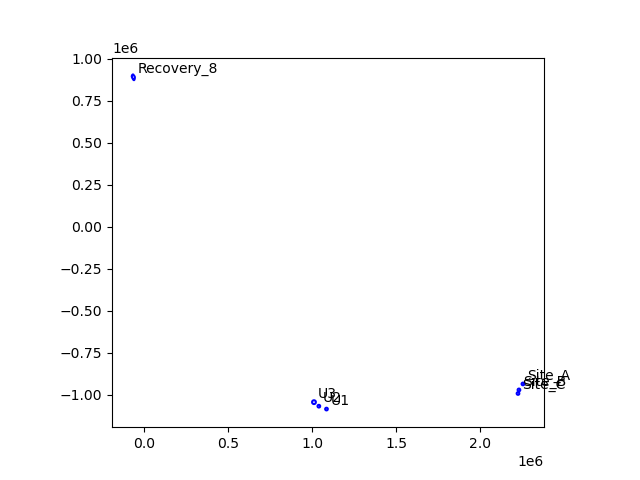

In [20]:
# Plot newly added lakes to very outlines look correct
fig, ax = plt.subplots()

# Filter rows on the 'name' column
filtered_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(['Recovery_8', 'Site_A', 'Site_B', 'Site_C', 'U1', 'U2', 'U3'])]

filtered_gdf.boundary.plot(ax=ax, color='blue')
# Iterate through the GeoDataFrame to annotate each polygon.
for idx, row in filtered_gdf.iterrows():
    # Use the centroid of each polygon for the annotation location.
    centroid = row['geometry'].centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

## Add lakes from studies not included in past lake inventories

<!-- ### Bell and others, 2007 -->

In [21]:
# # Bell and others, 2007, https://doi.org/10.1038/nature05554
# # Upper Recovery Ice Stream Lakes

# # Read shape file into geodataframe
# file_path = 'input/lake_outlines/Bell2007_upperRecovery_lakes/recovery.geojson'
# Bell2007_outlines = gpd.read_file(file_path)

# # Display geodataframe
# Bell2007_outlines

In [22]:
# # Drop columns unnecessary to our analysis
# Bell2007_outlines.drop(columns=['Id', 'Shape_Leng', 'Shape_Area'], inplace=True)

# # Rename the column 'OBJECTID' to 'name'
# Bell2007_outlines = Bell2007_outlines.rename(columns={'OBJECTID': 'name'})

# # Display geodataframe
# Bell2007_outlines

In [23]:
# # Plot lakes to rename to match publication
# fig, ax = plt.subplots()

# Bell2007_outlines.boundary.plot(ax=ax, color='blue')
# # Iterate through the GeoDataFrame to annotate each polygon.
# for idx, row in Bell2007_outlines.iterrows():
#     # Use the centroid of each polygon for the annotation location.
#     centroid = row['geometry'].centroid
#     ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
# plt.show()

In [24]:
# # Replace specific values in the 'name' column (assuming these are integers)
# value_replacements = {1: 'Recovery_D', 2: 'Recovery_C', 3: 'Recovery_B', 4: 'Recovery_A'}

# # Replace the values in the 'name' column based on the dictionary
# Bell2007_outlines['name'] = Bell2007_outlines['name'].replace(value_replacements)

# # Display the updated dataframe
# Bell2007_outlines

In [25]:
# # Plot lakes to ensure rename done properly
# fig, ax = plt.subplots()

# Bell2007_outlines.boundary.plot(ax=ax, color='blue')
# # Iterate through the GeoDataFrame to annotate each polygon.
# for idx, row in Bell2007_outlines.iterrows():
#     # Use the centroid of each polygon for the annotation location.
#     centroid = row['geometry'].centroid
#     ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
# plt.show()

In [26]:
# # Iterate over each row of the Bell2007_outlines GeoDataFrame
# for index, row in Bell2007_outlines.iterrows():
#     # Extract name and geometry for each row
#     name = row['name']
#     geometry = row['geometry']
    
#     # Create a temporary GeoDataFrame for the current lake geometry
#     lake_gdf = gpd.GeoDataFrame([[geometry]], columns=['geometry'], geometry='geometry', crs=Bell2007_outlines.crs)
    
#     # Convert CRS to 4326 for geodesic area calculations
#     lake_gdf = lake_gdf.to_crs('EPSG:4326')
    
#     # Calculate the area using geodesic area calculation
#     area = lake_gdf['geometry'].apply(
#         lambda poly: abs(geod.polygon_area_perimeter(
#             poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None
#     )[0]
    
#     # Convert CRS back to 3031 for plotting
#     lake_gdf = lake_gdf.to_crs('EPSG:3031')
    
#     # Set citation information
#     cite = 'Bell and others, 2007, Nature, doi:10.1038/nature05554'
    
#     # Create a GeoDataFrame for the current lake and append it to the static lakes inventory
#     gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns, geometry=[geometry])
#     gdf.crs = stationary_outlines_gdf.crs
    
#     # Ensure the new lake entry isn't already in the stationary_outlines_gdf (to avoid duplicates)
#     gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
    
#     # Concatenate the new entry to the stationary_outlines_gdf
#     stationary_outlines_gdf = gpd.GeoDataFrame(pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True), crs=stationary_outlines_gdf.crs)

# # Display the updated stationary_outlines_gdf
# stationary_outlines_gdf

### Hoffman and others, 2020

In [27]:
# Hoffman and others, 2020, https://doi.org/10.5194/tc-14-4603-2020
# Redelineations of two Thwaites lakes
# Obtained lake outlines from author Hoffman

# Read lake outline geojsons into geodataframes
file_path = 'input/lake_outlines/Hoffman2020_subglacial_lakes/Thw124.geojson'
Hoffman2020_Thw124 = gpd.read_file(file_path)

file_path = 'input/lake_outlines/Hoffman2020_subglacial_lakes/Thw142.geojson'
Hoffman2020_Thw142 = gpd.read_file(file_path)

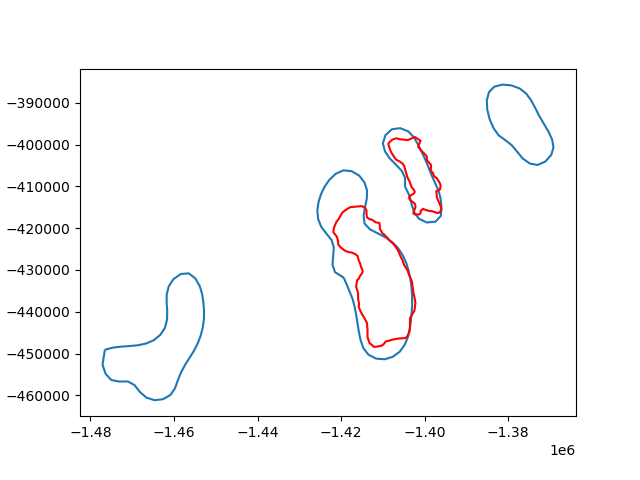

In [28]:
fig, ax = plt.subplots()

stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170'])].boundary.plot(ax=ax)
Hoffman2020_Thw124.boundary.plot(ax=ax, color='red')
Hoffman2020_Thw142.boundary.plot(ax=ax, color='red')
plt.show()

Hoffman and others redelineated Thw124 and Thw142; however outlines are largely similar to Smith and others, 2017 delineations and outlines were not publicly available at time of investigation, so we use the Smith others, 2017 delineations contained in SF18 inventory

In [29]:
# Hoffman and others, 2020 (within Livingstone and others, 2022 inventory as lake points)
# but multiple lakes aggregated into single HG point

# Takahe lakes (TL; named after nearby Mt. Takahe) on Haynes Glacier
# & Western Thwaites (WT) lake
# detailed in Hoffman and others, 2020 supplement
# https://tc.copernicus.org/articles/14/4603/2020/tc-14-4603-2020-supplement.pdf

# Make list of lake names
lake_names = ['TL96', 'TL108', 'TL115', 'TL122', 'WT']

for lake_name in lake_names:
    # Load geojson into geodataframe
    lake_geojson_path = f'input/lake_outlines/Hoffman2020_subglacial_lakes/{lake_name}.geojson'
    lake_gdf = gpd.read_file(lake_geojson_path)

    # Extract name and geometry
    name = lake_gdf['id'].values[0]
    geometry = lake_gdf['geometry'].iloc[0]
    
    # Convert CRS to 4326 for geodesic area calculations
    lake_gdf = lake_gdf.to_crs('EPSG:4326')
    area = lake_gdf['geometry'].apply(lambda poly: abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None)[0]
    
    # Convert CRS back to 3031 for plotting
    lake_gdf = lake_gdf.to_crs('EPSG:3031')
    cite = 'Hoffman and others, 2020, Cryosphere, doi:10.5194/tc-14-4603-2020'
    
    # Create a GeoDataFrame for the current lake and append it if it's not already present
    gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns)
    gdf.crs = stationary_outlines_gdf.crs
    gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
    stationary_outlines_gdf = pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True)

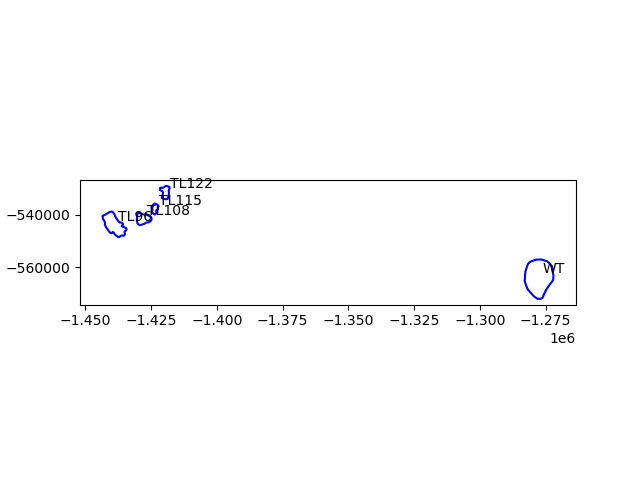

In [30]:
fig, ax = plt.subplots()

# Filter rows on the 'name' column
filtered_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(lake_names)]

filtered_gdf.boundary.plot(ax=ax, color='blue')
# Iterate through the GeoDataFrame to annotate each polygon.
for idx, row in filtered_gdf.iterrows():
    # Use the centroid of each polygon for the annotation location.
    centroid = row['geometry'].centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

### Neckel and others, 2020

In [31]:
# Neckel and others, 2020 (publication not included in Livingstone and others, 2022 inventory)
# on active subglacial lakes on Jutulstraumen Glacier
# https://doi.org/10.1594/PANGAEA.927120

# Read shape file into geodataframe
file_path = 'input/lake_outlines/Neckel2021_Jutulstraumen_lakes/JG_interferometry_lake_outlines.shp'
Neckel2020_outlines = gpd.read_file(file_path)

# Display geodataframe
Neckel2020_outlines

,Date,Year,Month,Movement,Feature,Lon,Lat,geometry
0,2017_1112_1124_1206_01,2017,11,uplift,D2_b,1.4390,-73.1821,"POLYGON ((46000.258 1842014.397, 46455.043 184..."
1,2017_1112_1124_1206_02,2017,11,subsidence,D1_b,1.8943,-73.1438,"POLYGON ((61125.377 1845053.779, 61359.548 184..."
2,2017_1112_1124_1206_03,2017,11,subsidence,D1_a,2.0457,-73.1429,"POLYGON ((67375.406 1843965.043, 67844.79 1843..."
3,2017_1206_1218_1230_01,2017,12,uplift,E2,1.3370,-73.3150,"POLYGON ((44021.847 1830735.929, 44222.857 183..."
4,2017_1206_1218_1230_02,2017,12,subsidence,E1,1.4330,-73.1930,"POLYGON ((44944.224 1841622.897, 45377.363 184..."
5,2020_0101_0113_0125_01,2020,1,uplift,F2,1.3450,-73.3220,"POLYGON ((40570.497 1825983.767, 41135.159 182..."
6,2020_0101_0113_0125_02,2020,1,subsidence,F1,2.0880,-73.3380,"POLYGON ((66809.882 1824720.853, 67159.086 182..."
7,2017_1112_1124_1206_01,2017,11,uplift,D2_a,1.7700,-73.1259,"POLYGON ((56114.824 1846982.083, 56646.246 184..."


In [32]:
# Drop columns unnecessary to our analysis
Neckel2020_outlines.drop(columns=['Date', 'Year', 'Month', 'Movement', 'Lon', 'Lat'], inplace=True)

# Rename 'Feature' col to 'Name' to match stationary_outlines_gdf
Neckel2020_outlines = Neckel2020_outlines.rename(columns={'Feature': 'name'})

# Display geodataframe
Neckel2020_outlines

,name,geometry
0,D2_b,"POLYGON ((46000.258 1842014.397, 46455.043 184..."
1,D1_b,"POLYGON ((61125.377 1845053.779, 61359.548 184..."
2,D1_a,"POLYGON ((67375.406 1843965.043, 67844.79 1843..."
3,E2,"POLYGON ((44021.847 1830735.929, 44222.857 183..."
4,E1,"POLYGON ((44944.224 1841622.897, 45377.363 184..."
5,F2,"POLYGON ((40570.497 1825983.767, 41135.159 182..."
6,F1,"POLYGON ((66809.882 1824720.853, 67159.086 182..."
7,D2_a,"POLYGON ((56114.824 1846982.083, 56646.246 184..."


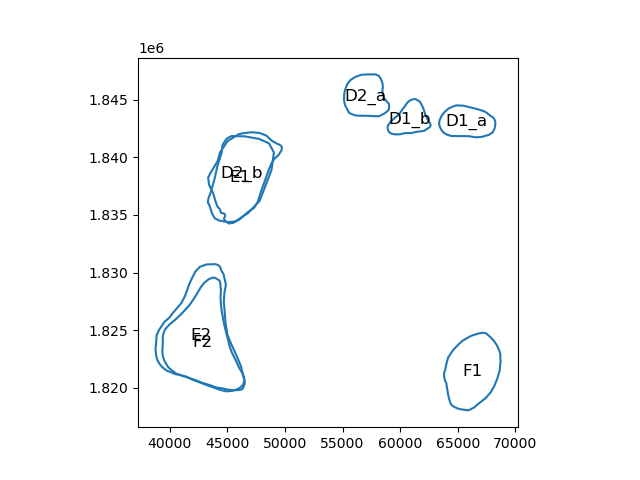

In [33]:
fig, ax = plt.subplots()

Neckel2020_outlines.boundary.plot(ax=ax)

# Adding labels to the center of each polygon
for idx, row in Neckel2020_outlines.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['name'], fontsize=12, ha='center', va='center')

In [34]:
# This is the only set of previously identified lakes that has spatiotemporally evolving outlines
# For simplicity, we collapse this spatiotemporal variability into a stationary outline that is 
# the unary union of all outlines of each lake

# Define the two sets of criteria
criterias = [['D2_b', 'E1'], ['E2', 'F2']]

for criteria in criterias:
    # Filter rows where 'Feature' matches the current set of criteria
    rows_to_combine = Neckel2020_outlines[Neckel2020_outlines['name'].isin(criteria)]

    # Check if we have at least two polygons to combine for the current criteria
    if len(rows_to_combine) >= 2:
        # Perform the union of the polygons
        combined_polygon = rows_to_combine['geometry'].unary_union

        # Create a new row with the combined geometry and any other necessary attributes
        new_row_data = {
            'geometry': combined_polygon,
            'name': 'Combined_' + '_'.join(criteria),  # Example of setting the Feature column
            # Set other attributes as needed
        }
        new_row = gpd.GeoDataFrame([new_row_data], crs=gdf.crs)

        # Use pandas.concat instead of append
        Neckel2020_outlines = pd.concat([Neckel2020_outlines, new_row], ignore_index=True)

    # Ensure you reference the correct GeoDataFrame when removing rows
    Neckel2020_outlines = Neckel2020_outlines[~Neckel2020_outlines['name'].isin(criteria)]

# Add citation column
Neckel2020_outlines['cite'] = 'Neckel and others, 2021, Geophys. Res. Lett., doi:10.1029/2021GL094472'

# Reset the index of the GeoDataFrame after all operations
Neckel2020_outlines = Neckel2020_outlines.reset_index(drop=True)

# Ensure GeoDataFrame is in EPSG:4326 for geodesic area calculation
if Neckel2020_outlines.crs != 'EPSG:4326':
    Neckel2020_outlines = Neckel2020_outlines.to_crs("EPSG:4326")
    
# Calculate the geodesic area for each polygon
Neckel2020_outlines['area (m^2)'] = Neckel2020_outlines.geometry.apply(
    lambda poly: abs(geod.polygon_area_perimeter(
        poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None)

# Convert to crs to epsg:3031
Neckel2020_outlines = Neckel2020_outlines.to_crs(3031)

# Add a prefix to all the names to indicate their locations on Jutulstraumen Glacier
Neckel2020_outlines['name'] = 'JG_' + Neckel2020_outlines['name']

# Add to stationary_outlines_gdf
gdf_diff = Neckel2020_outlines[~Neckel2020_outlines['name'].isin(stationary_outlines_gdf['name'])]
stationary_outlines_gdf = pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True)

/tmp/ipykernel_397/3453532874.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_polygon = rows_to_combine['geometry'].unary_union
/tmp/ipykernel_397/3453532874.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_polygon = rows_to_combine['geometry'].unary_union


In [35]:
Neckel2020_outlines

,name,geometry,cite,area (m^2)
0,JG_D1_b,"POLYGON ((61125.377 1845053.779, 61359.548 184...","Neckel and others, 2021, Geophys. Res. Lett., ...",7.190591e+06
1,JG_D1_a,"POLYGON ((67375.406 1843965.043, 67844.79 1843...","Neckel and others, 2021, Geophys. Res. Lett., ...",1.068865e+07
2,JG_F1,"POLYGON ((66809.882 1824720.853, 67159.086 182...","Neckel and others, 2021, Geophys. Res. Lett., ...",2.447534e+07
3,JG_D2_a,"POLYGON ((56114.824 1846982.083, 56646.246 184...","Neckel and others, 2021, Geophys. Res. Lett., ...",1.145730e+07
4,JG_Combined_D2_b_E1,"POLYGON ((45377.363 1841850.477, 45723.017 184...","Neckel and others, 2021, Geophys. Res. Lett., ...",3.391586e+07
5,JG_Combined_E2_F2,"POLYGON ((46521.167 1820579.145, 46508.756 182...","Neckel and others, 2021, Geophys. Res. Lett., ...",5.225521e+07


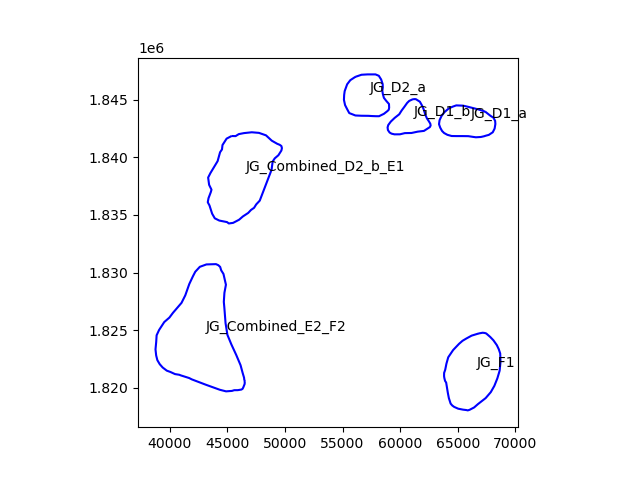

In [36]:
fig, ax = plt.subplots()

# Filter rows on the 'name' column
filtered_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(Neckel2020_outlines['name'].tolist())]

filtered_gdf.boundary.plot(ax=ax, color='blue')
# Iterate through the GeoDataFrame to annotate each polygon.
for idx, row in filtered_gdf.iterrows():
    # Use the centroid of each polygon for the annotation location.
    centroid = row['geometry'].centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

### Siegfried and Fricker, 2021

In [136]:
# Siegfried and Fricker, 2021 (publication not included in Livingstone and others, 2022 inventory)
# These are discussed but no figures contain outlines; Lead author, Siegfried, confirmed no outlines were generated
# Guestimated centroid point and approximate area

# Lower Conway Subglacial Lake
name = 'LowerConwaySubglacialLake'
area = 10e6
geometry = Point(-308000, -509000).buffer(math.sqrt(area / math.pi))
cite = 'Siegfried and Fricker, 2021, Geophys. Res. Lett., doi:10.1029/2020GL091089'
gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns, geometry=[geometry])
gdf.crs = stationary_outlines_gdf.crs
gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
stationary_outlines_gdf = gpd.GeoDataFrame(pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True), crs=stationary_outlines_gdf.crs)

# Lower Subglacial Lake Mercer
name = 'LowerMercerSubglacialLake'
area = 10e6
geometry = Point(-282000, -502000).buffer(math.sqrt(area / math.pi))
cite = 'Siegfried and Fricker, 2021, Geophys. Res. Lett., doi:10.1029/2020GL091089'
gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns, geometry=[geometry])
gdf.crs = stationary_outlines_gdf.crs
gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
stationary_outlines_gdf = gpd.GeoDataFrame(pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True), crs=stationary_outlines_gdf.crs)

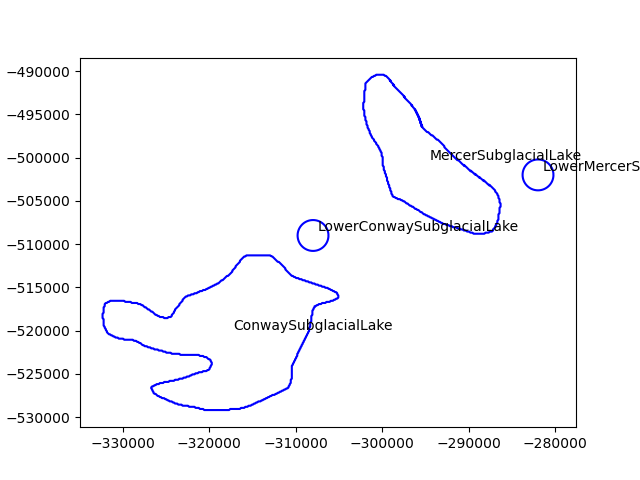

In [137]:
fig, ax = plt.subplots()

# Filter rows on the 'name' column
filtered_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(['MercerSubglacialLake', 'LowerMercerSubglacialLake', 'ConwaySubglacialLake', 'LowerConwaySubglacialLake'])]

filtered_gdf.boundary.plot(ax=ax, color='blue')
# Iterate through the GeoDataFrame to annotate each polygon.
for idx, row in filtered_gdf.iterrows():
    # Use the centroid of each polygon for the annotation location.
    centroid = row['geometry'].centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

### Hodgson and others, 2022

In [138]:
# Area of lake too small to be compatiable with 1-km spatial resolution datasets:

# Hodgson and others, 2022 (publication not included in Livingstone and others, 2022 inventory)
# No figures in publication contain outlines; emailed corresponding author, Hodgson, and confirmed none were generated

# # Phobos ice collapse structure on Mars Glacier

# # Coordinates in degrees, minutes, seconds
# latitude_dms = (71, 51, 1)
# longitude_dms = (68, 28, 36)

# # Convert DMS to decimal degrees
# def dms_to_decimal(degrees, minutes, seconds):
#     return degrees + (minutes / 60) + (seconds / 3600)

# latitude_decimal = dms_to_decimal(*latitude_dms)
# longitude_decimal = dms_to_decimal(*longitude_dms)

# # Considering the direction (S and W are negative)
# latitude_decimal = -latitude_decimal
# longitude_decimal = -longitude_decimal

# name = 'Mars'
# area = 0.067e6  # km2; Unclear if this is planar or geodesic area
# lon = latitude_decimal
# lat = longitude_decimal
# geometry = Point(ll2ps(lon, lat)).buffer(math.sqrt(area / math.pi))
# cite = 'Hodgson and others, 2022, Cryosphere, doi:10.5194/tc-16-4797-2022'
# gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns, geometry=[geometry])
# gdf.crs = stationary_outlines_gdf.crs
# gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
# stationary_outlines_gdf = gpd.GeoDataFrame(pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True), crs=stationary_outlines_gdf.crs)

# Other doline-style lakes listed in their Fig. 1 may be investigated with higher resolution data when it's available

In [139]:
# fig, ax = plt.subplots()

# # Filter rows on the 'name' column
# filtered_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(['Mars'])]

# filtered_gdf.boundary.plot(ax=ax, color='blue')
# # Iterate through the GeoDataFrame to annotate each polygon.
# for idx, row in filtered_gdf.iterrows():
#     # Use the centroid of each polygon for the annotation location.
#     centroid = row['geometry'].centroid
#     ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
# plt.show()

### Arthur and others, 202X

In [140]:
# Arthur and others, 202X (publication not included in Livingstone and others, 2022 inventory)
# Active subglacial lakes along Dronning Maud Land
# https://doi.org/10.5194/egusphere-2024-1704
# Lake outline files:
# https://doi.org/10.21334/npolar.2024.ab777130

# Read shape file into geodataframe
file_path = 'input/lake_outlines/Arthur202X_lakes/DML_Lakes_Combined.shp'
Arthur202X_outlines = gpd.read_file(file_path)

# Display geodataframe
Arthur202X_outlines

,Name,Lat,Lon,Area,IceSpeed,BM2_thick,BM_thick,BedElev,Category,REMA_Strip,GL_Dist,geometry
0,V1,-70.99,8.19,0.0,60.0,1247.0,1321.0,-552.0,High-confidence,n/a,54.0,"POLYGON ((298138.482 2063863.504, 298561.816 2..."
1,L1,-70.67,13.97,40.1,19.0,1020.0,1019.0,-558.0,High-confidence,"25/1/2020, 15/2/2021, 12/9/2015, 10/12/2016",32.0,"POLYGON ((513963.138 2054543.662, 513726.886 2..."
2,M1,-70.98,19.60,0.0,152.0,828.0,881.0,-724.0,High-confidence,n/a,5.0,"POLYGON ((701306.715 1964856.221, 701835.883 1..."
3,M2,-71.07,19.87,0.0,86.0,1008.0,924.0,-633.0,High-confidence,n/a,15.0,"POLYGON ((705857.557 1952447.238, 706201.516 1..."
4,R1,-71.10,27.41,39.4,172.0,1137.0,1193.0,-737.0,High-confidence,"22/10/2019, 10/1/2021, 7/12/2016, 21/12/2017",19.0,"POLYGON ((957966.814 1836518.092, 957619.547 1..."
5,R2,-71.19,32.53,21.5,17.0,1238.0,1391.0,-29.0,Provisionally active,"18/1/2021, 28/12/2022",115.0,"POLYGON ((1068739.262 1732646.489, 1069480.097..."
6,R3,-71.44,31.65,0.0,64.0,1503.0,1547.0,-162.0,Provisionally active,n/a,136.0,"POLYGON ((1107079.238 1734498.055, 1106239.208..."


In [141]:
# Keep only the 'name' and 'geometry' columns
Arthur202X_outlines = Arthur202X_outlines[['Name', 'geometry']]

# Rename the column 'OBJECTID' to 'name'
Arthur202X_outlines = Arthur202X_outlines.rename(columns={'Name': 'name'})

# Display the updated GeoDataFrame
Arthur202X_outlines

,name,geometry
0,V1,"POLYGON ((298138.482 2063863.504, 298561.816 2..."
1,L1,"POLYGON ((513963.138 2054543.662, 513726.886 2..."
2,M1,"POLYGON ((701306.715 1964856.221, 701835.883 1..."
3,M2,"POLYGON ((705857.557 1952447.238, 706201.516 1..."
4,R1,"POLYGON ((957966.814 1836518.092, 957619.547 1..."
5,R2,"POLYGON ((1068739.262 1732646.489, 1069480.097..."
6,R3,"POLYGON ((1107079.238 1734498.055, 1106239.208..."


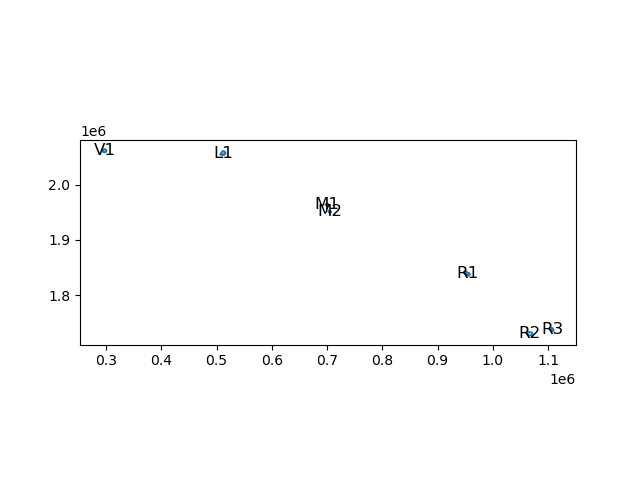

In [142]:
fig, ax = plt.subplots()

Arthur202X_outlines.boundary.plot(ax=ax)

# Adding labels to the center of each polygon
for idx, row in Arthur202X_outlines.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['name'], fontsize=12, ha='center', va='center')

In [143]:
# Iterate over each row of the Arthur202X_outlines GeoDataFrame
for index, row in Arthur202X_outlines.iterrows():
    # Extract name and geometry for each row
    name = row['name']
    geometry = row['geometry']
    
    # Create a temporary GeoDataFrame for the current lake geometry
    lake_gdf = gpd.GeoDataFrame([[geometry]], columns=['geometry'], geometry='geometry', crs=Arthur202X_outlines.crs)
    
    # Convert CRS to 4326 for geodesic area calculations
    lake_gdf = lake_gdf.to_crs('EPSG:4326')
    
    # Calculate the area using geodesic area calculation
    area = lake_gdf['geometry'].apply(
        lambda poly: abs(geod.polygon_area_perimeter(
            poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None
    )[0]
    
    # Convert CRS back to 3031 for plotting
    lake_gdf = lake_gdf.to_crs('EPSG:3031')
    
    # Set citation information
    cite = 'Arthur and others, 202X, EGUSphere, doi:10.5194/egusphere-2024-1704'
    
    # Create a GeoDataFrame for the current lake and append it to the static lakes inventory
    gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=stationary_outlines_gdf.columns, geometry=[geometry])
    gdf.crs = stationary_outlines_gdf.crs
    
    # Ensure the new lake entry isn't already in the stationary_outlines_gdf (to avoid duplicates)
    gdf_diff = gdf[~gdf['name'].isin(stationary_outlines_gdf['name'])]
    
    # Concatenate the new entry to the stationary_outlines_gdf
    stationary_outlines_gdf = gpd.GeoDataFrame(pd.concat([stationary_outlines_gdf, gdf_diff], ignore_index=True), crs=stationary_outlines_gdf.crs)

# Display the updated stationary_outlines_gdf
stationary_outlines_gdf

,name,geometry,area (m^2),cite
0,Bindschadler_1,"POLYGON ((-792264.327 -691480.857, -791281.458...",1.943146e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
1,Bindschadler_2,"POLYGON ((-842788.063 -708464.24, -842354.948 ...",1.072249e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
2,Bindschadler_3,"POLYGON ((-874893.221 -654533.044, -876415.673...",1.404559e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
3,Bindschadler_4,"POLYGON ((-828821.778 -584874.415, -828822.032...",2.816411e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
4,Bindschadler_5,"POLYGON ((-858067.46 -573467.564, -858714.391 ...",3.923966e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
...,...,...,...,...
153,M1,"POLYGON ((701306.715 1964856.221, 701835.883 1...",1.190202e+07,"Arthur and others, 202X, EGUSphere, doi:10.519..."
154,M2,"POLYGON ((705857.557 1952447.238, 706201.516 1...",1.298180e+07,"Arthur and others, 202X, EGUSphere, doi:10.519..."
155,R1,"POLYGON ((957966.814 1836518.092, 957619.547 1...",3.949683e+07,"Arthur and others, 202X, EGUSphere, doi:10.519..."
156,R2,"POLYGON ((1068739.262 1732646.489, 1069480.097...",4.656753e+07,"Arthur and others, 202X, EGUSphere, doi:10.519..."


# Finalize revised Sauthoff other others (202X) inventory

In [144]:
# Find invalid geometries
invalid_rows = stationary_outlines_gdf[~stationary_outlines_gdf.is_valid]

# Display the invalid rows
print(invalid_rows)

        name                                           geometry    area (m^2)  \
25   Cook_E2  POLYGON ((765592.392 -1714713.856, 765682.174 ...  2.680933e+08   
85      Mac1  POLYGON ((-629350.01 -889125.01, -629325.01 -8...  1.563754e+08   
86      Mac2  POLYGON ((-657250.02 -890550.04, -657249.98 -8...  1.457161e+08   
87      Mac3  POLYGON ((-642325.01 -883925, -642449.98 -8839...  1.502500e+08   
88      Mac4  POLYGON ((-739324.97 -857799.96, -739199.98 -8...  7.520909e+07   
89      Mac5  POLYGON ((-734575.01 -842800.02, -734449.99 -8...  5.998647e+07   
103     Rec2  POLYGON ((-389950.015 915200.035, -389824.971 ...  7.096422e+08   
105     Rec4  POLYGON ((-174200.004 944325.029, -174200 9442...  2.299425e+08   
106     Rec5  POLYGON ((-128199.995 941949.982, -128200.002 ...  2.849787e+08   

                                                  cite  
25   McMillan and others, 2013, Geophys. Res. Lett....  
85   Fricker and others, 2010, J. Glac., doi:10.318...  
86   Fricker and o

In [146]:
# Repair invalid geometries
stationary_outlines_gdf.loc[~stationary_outlines_gdf.is_valid, 'geometry'] = stationary_outlines_gdf[~stationary_outlines_gdf.is_valid].geometry.buffer(0)

# Check if there are still any invalid geometries
print(stationary_outlines_gdf[~stationary_outlines_gdf.is_valid])

Empty GeoDataFrame
Columns: [name, geometry, area (m^2), cite]
Index: []


Two lakes (Bindschadler_1 and _2) were renamed in [Carter and others (2011)](https://doi.org/10.3189/002214311798843421) to Mac7 and Mac8 likely under the assumption that these two lakes are within the subglacial watershed of MacAyeal ice stream, however, the renaming was not documented in that paper and so these lake outlines were duplicative to Bindschadler_1 and _2 in the SF18 inventory. 

Watershed delineation indicates that one of these lakes is likely in the MacAyeal subglacial watershed; however, we feel this renaming is unnecessary and confusing, so we opt to use the original names for these two lakes (Bindschadler_1 and _2).

In [147]:
# Drop Mac7 and Mac8 outlines from stationary_outlines_gdf that were renamed from Bindschadler_1 and _2
stationary_outlines_gdf = stationary_outlines_gdf[~stationary_outlines_gdf['name'].isin(['Mac7', 'Mac8'])]

[Carter and others (2013)](https://doi.org/10.3189/2013JoG13J085) defined Lake7 and Lake8 (originally from [Fricker and Scambos (2009)](https://doi.org10.3189/002214309788608813)) as a lake system, Lake78.

In [148]:
# Ensure the reference for this lake reflects that
SF18_outlines[SF18_outlines['cite'].str.contains('Carter and others, 2013', case=False, na=False)]

,name,geometry,area (m^2),cite
82,Lake78,"MULTIPOLYGON (((-257325.009 -525800.047, -2571...",233.002708,"Carter and others, 2013, J. Glac., doi:10.3189..."


In [149]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

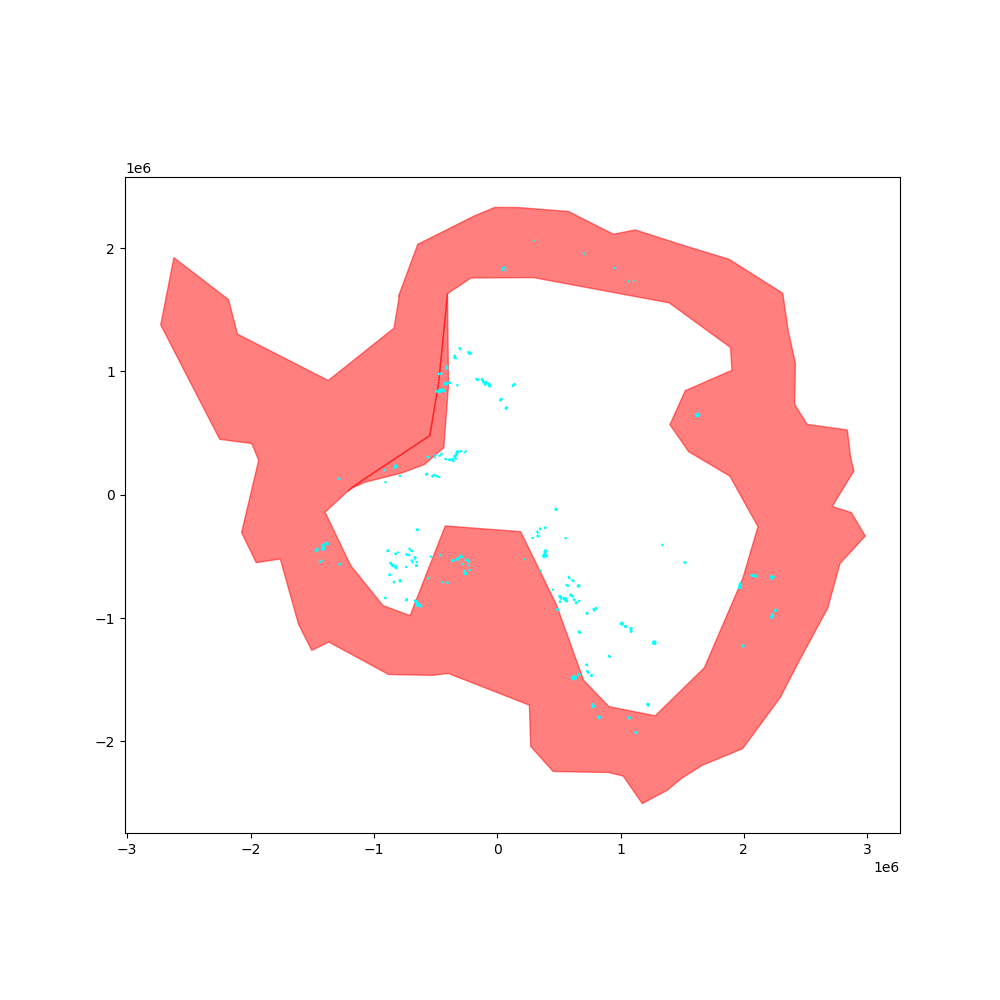

In [150]:
# Plot stationary_outlines_gdf with CS2 SARIn mode mask
fig, ax = plt.subplots(figsize=(10,10))
gdf_SARIn_3_1.plot(ax=ax, edgecolor='red', facecolor='red', label='SARIn mode mask 3.1', alpha=0.5)
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, edgecolor='red', facecolor='red', label='SARIn mode mask 3.6', alpha=0.5)
stationary_outlines_gdf.plot(ax=ax, edgecolor='cyan', facecolor='cyan')
plt.show()

In [151]:
# Create a column to indicate the time period each lake has CS2 SARIn coverage if any

# Combining the SARIn mode masks the occur during the CS2-IS2 analysis time period (2010-2023)
combined_geom = unary_union([gdf_SARIn_3_1, gdf_SARIn_3_1_3_6_diff])

# Creating a new GeoDataFrame with the combined geometry
gdf_SARIn_3_1_3_6 = gpd.GeoDataFrame(geometry=[combined_geom])
gdf_SARIn_3_1_3_6.crs = 'epsg:3031'

# Use the 'within' method to find lakes that have CS2 SARIn coverage during the different SARIn mode mask versions
# See 0_preprocess_data.ipynb for more info
CS2_SARIn_3_1_col = stationary_outlines_gdf.geometry.within(gdf_SARIn_3_1.geometry.iloc[0])
CS2_SARIn_3_1_3_6_col = stationary_outlines_gdf.geometry.within(gdf_SARIn_3_1_3_6.geometry.iloc[0])

# Conditions
condition1 = (CS2_SARIn_3_1_col == True) & (CS2_SARIn_3_1_3_6_col == True)
condition2 = (CS2_SARIn_3_1_col == False) & (CS2_SARIn_3_1_3_6_col == True)

# Choices based on the conditions
choices = ['2010.5-2018.75', '2013.75-2018.75']

# Use np.select to apply conditions and choices
stationary_outlines_gdf['CS2_SARIn_time_period'] = np.select([condition1, condition2], choices, default=pd.NA)

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [152]:
# Drop outlines from stationary_outlines_gdf that are part of SF18_outlines (indexes 0:130)
# and Recovery_8 (idx 131) originally from S09_outlines
stationary_outlines_notinSF18_gdf = stationary_outlines_gdf.copy(deep=True)
stationary_outlines_notinSF18_gdf.drop(stationary_outlines_notinSF18_gdf.iloc[0:132].index, inplace=True)

In [153]:
# Sort the GeoDataFrame by the 'name' column
stationary_outlines_gdf = stationary_outlines_gdf.sort_values(by='name')
stationary_outlines_notinSF18_gdf = stationary_outlines_notinSF18_gdf.sort_values(by='name')

# Resetting the index of the sorted GeoDataFrame
stationary_outlines_gdf = stationary_outlines_gdf.reset_index(drop=True)
stationary_outlines_notinSF18_gdf = stationary_outlines_notinSF18_gdf.reset_index(drop=True)

In [154]:
# Display geodataframe
stationary_outlines_gdf

,name,geometry,area (m^2),cite,CS2_SARIn_time_period
0,Bindschadler_1,"POLYGON ((-792264.327 -691480.857, -791281.458...",1.943146e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",<NA>
1,Bindschadler_2,"POLYGON ((-842788.063 -708464.24, -842354.948 ...",1.072249e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",<NA>
2,Bindschadler_3,"POLYGON ((-874893.221 -654533.044, -876415.673...",1.404559e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",<NA>
3,Bindschadler_4,"POLYGON ((-828821.778 -584874.415, -828822.032...",2.816411e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",<NA>
4,Bindschadler_5,"POLYGON ((-858067.46 -573467.564, -858714.391 ...",3.923966e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",<NA>
...,...,...,...,...,...
151,Whillans_6,"POLYGON ((-451544.869 -488823.261, -451209.964...",7.458477e+07,"Smith and others, 2009, J. Glac., doi:10.3189/...",2010.5-2018.75
152,Whillans_7,"POLYGON ((-543163.376 -500759.165, -542800.367...",7.696570e+07,"Smith and others, 2009, J. Glac., doi:10.3189/...",<NA>
153,Whillans_8,"POLYGON ((-654478.748 -281124.56, -653777.327 ...",1.625714e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",<NA>
154,Wilkes_1,"POLYGON ((2214185.18 -666018.604, 2214317.389 ...",5.880773e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",2010.5-2018.75


In [155]:
# Display geodataframe
stationary_outlines_notinSF18_gdf

,name,geometry,area (m^2),cite,CS2_SARIn_time_period
0,JG_Combined_D2_b_E1,"POLYGON ((45377.363 1841850.477, 45723.017 184...",3.391586e+07,"Neckel and others, 2021, Geophys. Res. Lett., ...",2010.5-2018.75
1,JG_Combined_E2_F2,"POLYGON ((46521.167 1820579.145, 46508.756 182...",5.225521e+07,"Neckel and others, 2021, Geophys. Res. Lett., ...",2010.5-2018.75
2,JG_D1_a,"POLYGON ((67375.406 1843965.043, 67844.79 1843...",1.068865e+07,"Neckel and others, 2021, Geophys. Res. Lett., ...",2010.5-2018.75
3,JG_D1_b,"POLYGON ((61125.377 1845053.779, 61359.548 184...",7.190591e+06,"Neckel and others, 2021, Geophys. Res. Lett., ...",2010.5-2018.75
4,JG_D2_a,"POLYGON ((56114.824 1846982.083, 56646.246 184...",1.145730e+07,"Neckel and others, 2021, Geophys. Res. Lett., ...",2010.5-2018.75
5,JG_F1,"POLYGON ((66809.882 1824720.853, 67159.086 182...",2.447534e+07,"Neckel and others, 2021, Geophys. Res. Lett., ...",2010.5-2018.75
6,LowerConwaySubglacialLake,"POLYGON ((-306215.876 -509000, -306224.467 -50...",1.000000e+07,"Siegfried and Fricker, 2021, Geophys. Res. Let...",2010.5-2018.75
7,LowerMercerSubglacialLake,"POLYGON ((-280215.876 -502000, -280224.467 -50...",1.000000e+07,"Siegfried and Fricker, 2021, Geophys. Res. Let...",2010.5-2018.75
8,M1,"POLYGON ((701306.715 1964856.221, 701835.883 1...",1.190202e+07,"Arthur and others, 202X, EGUSphere, doi:10.519...",2010.5-2018.75
9,M2,"POLYGON ((705857.557 1952447.238, 706201.516 1...",1.298180e+07,"Arthur and others, 202X, EGUSphere, doi:10.519...",2010.5-2018.75


In [156]:
# Export geodataframes to geojson for future use
S09_outlines.to_file('output/lake_outlines/stationary_outlines/S09_outlines.geojson', driver='GeoJSON')
SF18_outlines.to_file('output/lake_outlines/stationary_outlines/SF18_outlines.geojson', driver='GeoJSON')
SF18_outlines_SF18only.to_file('output/lake_outlines/stationary_outlines/SF18_outlines_SF18only.geojson', driver='GeoJSON')
stationary_outlines_gdf.to_file('output/lake_outlines/stationary_outlines/stationary_outlines_gdf.geojson', driver='GeoJSON')
stationary_outlines_notinSF18_gdf.to_file('output/lake_outlines/stationary_outlines/stationary_outlines_notinSF18_gdf.geojson', driver='GeoJSON')

In [157]:
stationary_outlines_notinSF18_gdf.to_file('output/lake_outlines/stationary_outlines/stationary_outlines_notinSF18_gdf.geojson', driver='GeoJSON')